In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from numpy import random
import datetime
import matplotlib.pyplot as plt

In [2]:
np.random.seed(123)

In [3]:
def make_LSTM_data(df):
    '''
    For the LSTM model, this is used with both the train and test data.
    For each building_name in dataframe df, take 3 months for input and 9 months for evaluating the model.
    The split day is taken randomly.
    '''
    buildings = df['building_name'].unique() #list of name of buildings
    num_buildings = len(buildings) # number of buildings
    num_obs = len(df) // num_buildings #number of observations per uilding
    three_months_hours = 24*90 #three months in hour
    nine_months_hours = len(df) - three_months_hours #nine month is defined to be the rest
    #make a long dataframe by duplicating
    for _ in range(2):
        df = pd.concat([df, df], ignore_index=True)
    #sort by building and index
    df = df.rename_axis('index').sort_values(['building_name', 'index']).reset_index(drop=True)
    X = pd.DataFrame() #data for fitting which contains three months data
    Y = pd.DataFrame() #data for evaluating which contains nine months data
    for building in buildings:
        start_day = datetime.timedelta(np.random.randint(low=0, high=num_obs//24)) #randomly pick a startday
        first_day = df[df['building_name']==building]['timestamp'].iloc[0]
        start_day = first_day + start_day
        start_idx = df[(df['building_name']==building) & (df['timestamp']==start_day)].index[0] #index of the start day
        x = df.iloc[start_idx: start_idx+three_months_hours] #three months data
        input_months = pd.concat([X, x], axis=0)
        y = df.iloc[start_idx+three_months_hours: start_idx+num_obs] #nine months data
        output_months = pd.concat([Y, y], axis=0)
    return input_months, output_months

In [4]:
def naive_model_2(X, Y, features):
    '''
    X: training set, 3 months
    Y: test set, 9 month
    features: features to use
    fit a RF model to each building
    '''
    features.append('building_name')
    X_train = X[features] #features for 3 months
    Y_train = X[['building_name', 'electricity']] #electricity labels for 3 months
    X_test = Y[features] #features for 9 months
    Y_test = Y[['building_name', 'electricity']] # electricity lables for 9 months
    features.remove('building_name')
    buildings = X['building_name'].unique()
    num_buildings = len(buildings)
    predicted = np.array([])
    observed = np.array([])
    #fit RF to each building
    for building in buildings:
        x_train = X_train[X_train['building_name']==building][features]
        y_train = Y_train[Y_train['building_name']==building]['electricity']
        x_test = X_test[X_test['building_name']==building][features]
        y_test = Y_test[Y_test['building_name']==building]['electricity']
        rf = RandomForestRegressor(n_estimators=50,
                               n_jobs=-1,
                               oob_score=True,
                               max_features=0.1, 
                               min_samples_leaf=6,
                               verbose = 1)
        rf.fit(x_train, y_train)
        y_fitted = rf.predict(x_test)
        predicted = np.append(predicted, y_fitted)
        observed = np.append(observed, y_test)
    return observed.reshape(num_buildings, len(observed)//num_buildings), predicted.reshape(num_buildings, len(predicted)//num_buildings)

In [5]:
train= pd.read_csv('../data/weather1_education_train.csv', index_col=0, parse_dates=['timestamp'])
train

,area,building_name,electricity,primary_space_usage,timestamp,TemperatureC,month,year,date,hour,...,hour_23,wkday_0,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,PSU_PrimClass,PSU_UnivClass
0,6149.0,PrimClass_Jacob,34.900002,PrimClass,2014-12-01 00:00:00,7.0,12,2014,1,0,...,0,1,0,0,0,0,0,0,1,0
1,6149.0,PrimClass_Jacob,32.700000,PrimClass,2014-12-01 01:00:00,5.0,12,2014,1,1,...,0,1,0,0,0,0,0,0,1,0
2,6149.0,PrimClass_Jacob,32.200000,PrimClass,2014-12-01 02:00:00,5.0,12,2014,1,2,...,0,1,0,0,0,0,0,0,1,0
3,6149.0,PrimClass_Jacob,32.300000,PrimClass,2014-12-01 03:00:00,6.0,12,2014,1,3,...,0,1,0,0,0,0,0,0,1,0
4,6149.0,PrimClass_Jacob,32.599998,PrimClass,2014-12-01 04:00:00,7.0,12,2014,1,4,...,0,1,0,0,0,0,0,0,1,0
5,6149.0,PrimClass_Jacob,31.700000,PrimClass,2014-12-01 05:00:00,7.0,12,2014,1,5,...,0,1,0,0,0,0,0,0,1,0
6,6149.0,PrimClass_Jacob,34.700000,PrimClass,2014-12-01 06:00:00,7.0,12,2014,1,6,...,0,1,0,0,0,0,0,0,1,0
7,6149.0,PrimClass_Jacob,68.199999,PrimClass,2014-12-01 07:00:00,8.0,12,2014,1,7,...,0,1,0,0,0,0,0,0,1,0
8,6149.0,PrimClass_Jacob,84.199996,PrimClass,2014-12-01 08:00:00,8.0,12,2014,1,8,...,0,1,0,0,0,0,0,0,1,0
9,6149.0,PrimClass_Jacob,89.500000,PrimClass,2014-12-01 09:00:00,8.0,12,2014,1,9,...,0,1,0,0,0,0,0,0,1,0


In [6]:
X, Y = make_LSTM_data(train)

In [7]:
features = ['area','month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'date_1', 'date_2', 'date_3', 'date_4', 'date_5', 'date_6', 'date_7',
       'date_8', 'date_9', 'date_10', 'date_11', 'date_12', 'date_13',
       'date_14', 'date_15', 'date_16', 'date_17', 'date_18', 'date_19',
       'date_20', 'date_21', 'date_22', 'date_23', 'date_24', 'date_25',
       'date_26', 'date_27', 'date_28', 'date_29', 'date_30', 'date_31',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'wkday_0',
       'wkday_1', 'wkday_2', 'wkday_3', 'wkday_4', 'wkday_5', 'wkday_6',
       'PSU_PrimClass']
y, y_fitted = naive_model_2(X, Y, features)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parall

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parall

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parall

In [8]:
y_fitted.shape

(50, 6597)

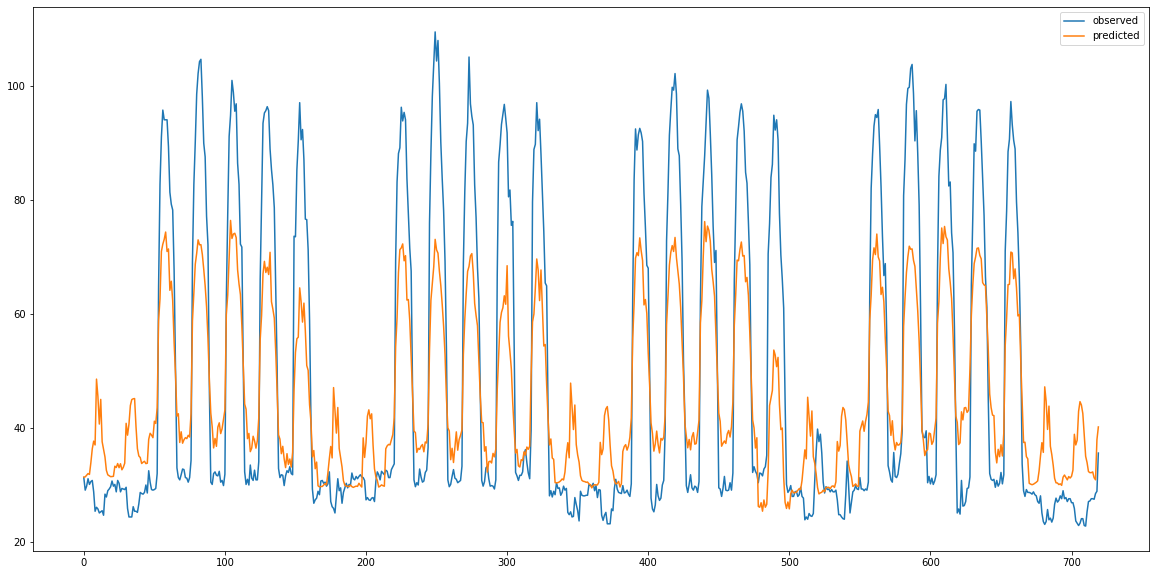

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(y[0][:720], label='observed')
plt.plot(y_fitted[0][:720], label='predicted')
plt.legend();

In [10]:
MAE = np.mean(np.abs(y-y_fitted))
MAE

8.315983457250265

In [11]:
MSE = np.mean(np.square(y-y_fitted))
MSE

263.24875808120555